Download torch and torchvision

In [1]:
# pip install torch

In [2]:
# pip install torchvision

Initialization

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler, Dataset, DataLoader, SubsetRandomSampler
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
import pandas as pd
import numpy as np

USE_GPU = True
dtype = torch.float32 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    device = torch.device('cpu')
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 4080 is available.


If the output is "using device: cpu": download CUDA toolkit (https://developer.nvidia.com/cuda-downloads)
https://pytorch.org/get-started/locally/

In [ ]:
# data augmentation
transform = v2.Compose([
                v2.ToImage(), 
                v2.ToDtype(torch.float32, scale=True),
                # v2.RandomHorizontalFlip(),
                v2.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.3, 0.3)),
                # v2.RandomChannelPermutation(),
                # v2.RandomErasing(p=0.5, scale=(0.05, 0.3), ratio=(1, 1), value='random'),
                v2.RandomRotation(degrees=30)])

In [5]:
class CropButtonDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    # return classes
    def classes(self):
        return self.data.classes

In [6]:
# creat a dictionary that maps index to label
data_dir='ClassificationDataset_label/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [7]:
button_train = CropButtonDataset('ClassificationDataset_label/train', transform=transform)
loader_train = DataLoader(button_train, batch_size=64, shuffle=True)

button_val = CropButtonDataset('ClassificationDataset_label/val', transform=transform)
loader_val = DataLoader(button_val, batch_size=14, shuffle=True)

button_test = CropButtonDataset('ClassificationDataset_label/test', transform=transform)
loader_test = DataLoader(button_test, batch_size=14, shuffle=False)

Check If load correctly

In [8]:
loader_train

In [9]:
for images, labels in loader_val:
    print("Batch loaded!")
    print("Images shape:", images.shape)
    print("Labels:", labels)
    break


Batch loaded!
Images shape: torch.Size([14, 3, 320, 320])
Labels: tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0])


Model setup

In [10]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [11]:
def check_accuracy_final(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc

def train(model, optimizer, epochs=10):
    x1 = list(range(len(loader_train) * epochs))
    x2 = []
    y1 = []
    y2 = []
    model = model.to(device=device)
    cnt = 0
    total_cnt = epochs * len(loader_train)
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y1.append(loss.item())

            print("iteration: " +  str(cnt) + "/" + str(total_cnt) + ": loss = " + str(loss.item()))
            if cnt % 5 == 0:
                acc_val = check_accuracy_final(loader_val, model)
                print("val_acc = " + str(acc_val))
                x2.append(cnt)
                y2.append(acc_val)

            cnt += 1
    return (x1, y1, x2, y2)

def plotpic(data):
  x1, y1, x2, y2 = data
  plt.figure()
  plt.plot(x1, y1, marker='.')
  plt.xlabel('Iteratoin')
  plt.ylabel('Loss')
  plt.title('Loss')
  plt.grid(True)

  plt.figure()
  plt.plot(x2, y2, marker='o')
  plt.xlabel('Iteratoin')
  plt.ylabel('Val Acc')
  plt.title('Val Acc')
  plt.grid(True)
  plt.show()

In [12]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.4),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.4),

    nn.Flatten(),
    nn.Linear(64 * 80 * 80, 256),
)

In [ ]:
sgdMNb = optim.SGD(model.parameters(), lr=1e-4,
                     momentum=0.8, nesterov=True)
adamw = optim.AdamW(model.parameters(), lr=1e-3,
                        weight_decay=1e-2)

Train

In [ ]:
data = train(model, adamw, epochs=10)

iteration: 0/100: loss = 5.2706618309021
val_acc = 0.42857142857142855
iteration: 1/100: loss = 1.353123664855957
iteration: 2/100: loss = 3.142934560775757
iteration: 3/100: loss = 7.162740707397461
iteration: 4/100: loss = 2.4426989555358887
iteration: 5/100: loss = 6.7418036460876465
val_acc = 0.5
iteration: 6/100: loss = 2.0045554637908936
iteration: 7/100: loss = 3.8428542613983154
iteration: 8/100: loss = 3.452411651611328
iteration: 9/100: loss = 5.863320350646973
iteration: 10/100: loss = 7.6418914794921875
val_acc = 0.5
iteration: 11/100: loss = 2.1939661502838135
iteration: 12/100: loss = 2.498776435852051
iteration: 13/100: loss = 5.0560173988342285
iteration: 14/100: loss = 3.551618814468384
iteration: 15/100: loss = 4.861946105957031
val_acc = 0.5
iteration: 16/100: loss = 6.930521488189697
iteration: 17/100: loss = 2.5166068077087402
iteration: 18/100: loss = 2.361325263977051
iteration: 19/100: loss = 1.3133870363235474
iteration: 20/100: loss = 1.849825143814087
val_acc

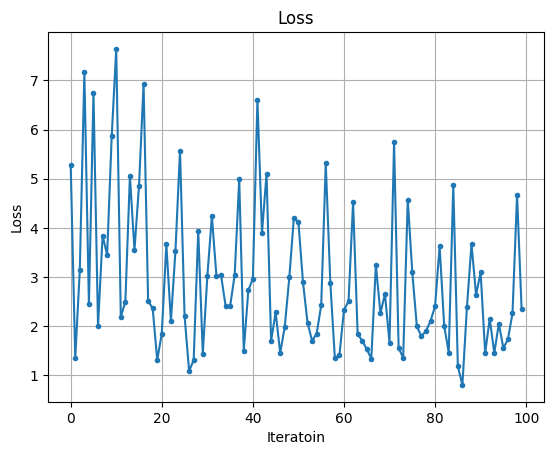

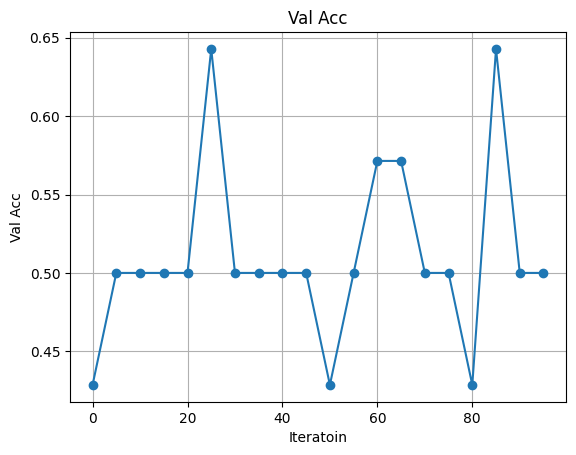

In [16]:
plotpic(data)